In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from dmba import  gainsChart, liftChart
from dmba.metric import AIC_score
sns.set(style="whitegrid")
pd.set_option("display.max_columns" , None)
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('Tayko.csv')

In [3]:
df.rename(columns={'Gender=male': 'Gender_male' ,'Web order' : 'Web_order' } , inplace= True )

In [4]:
#columns to remove
useless= ['sequence_number']
target= ['Purchase','Spending']
features= [col for col in df.columns if (col not in target and col not in useless)]
binary_cols= [col for col in features if col not in ('last_update_days_ago', '1st_update_days_ago' ,'Freq')]
binary_non_source_cols=[col for col in binary_cols if "source" not in col ]
df_X = df[features]
df_y = df[target]

In [5]:
all_data=pd.concat([df_X, df_y], axis = 1)
all_data.head()
all_data=all_data[df['Purchase']==1]
all_data.reset_index(drop=True,inplace=True)


In [6]:
df_X = all_data[[col for col in all_data.columns if col not in target]]
df_y = all_data[target]

In [7]:
df.columns

Index(['sequence_number', 'US', 'source_a', 'source_c', 'source_b', 'source_d',
       'source_e', 'source_m', 'source_o', 'source_h', 'source_r', 'source_s',
       'source_t', 'source_u', 'source_p', 'source_x', 'source_w', 'Freq',
       'last_update_days_ago', '1st_update_days_ago', 'Web_order',
       'Gender_male', 'Address_is_res', 'Purchase', 'Spending'],
      dtype='object')

# Visualizations

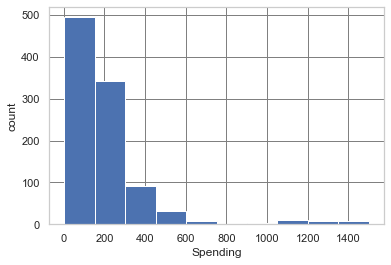

In [8]:
fig, ax = plt.subplots()
ax.hist(all_data.Spending)
ax.set_axisbelow(True)
ax.grid(which='major', color='grey', linestyle='-')
ax.set_xlabel('Spending'); ax.set_ylabel('count')
plt.show()


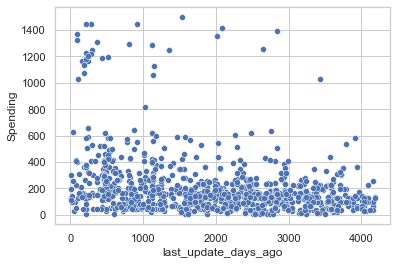

In [9]:
sns.scatterplot(data=all_data, x="last_update_days_ago", y="Spending");

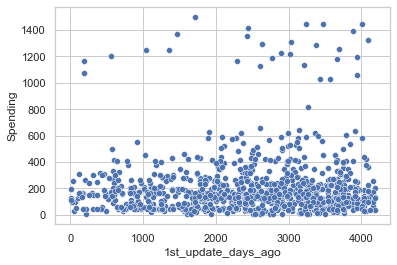

In [10]:
sns.scatterplot(data=all_data, x="1st_update_days_ago", y="Spending");

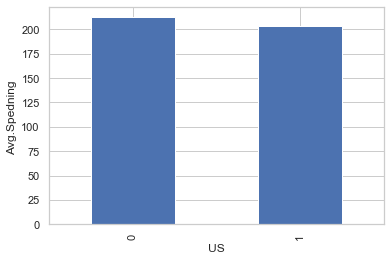

In [11]:
ax = all_data.groupby('US').mean().Spending.plot(kind='bar')
ax.set_ylabel('Avg.Spedning ');

Text(0.5, 1.0, 'Spending distribution within and outside US')

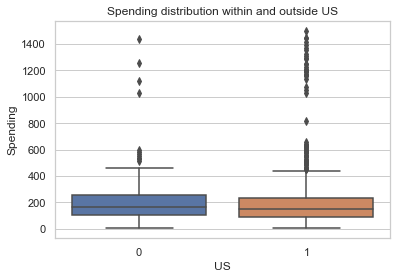

In [12]:
ax = sns.boxplot(y='Spending', x='US', data=all_data);
ax.set_ylabel('Spending')
plt.suptitle('') # Suppress the titles
plt.title('Spending distribution within and outside US')


Text(0.5, 1.0, 'Spending distribution within and outside US')

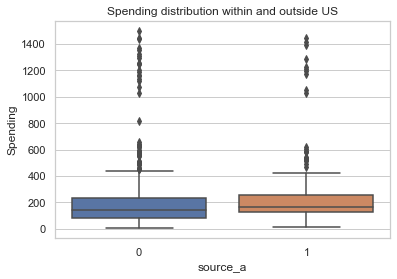

In [13]:
ax = sns.boxplot(y='Spending', x='source_a', data=all_data);
ax.set_ylabel('Spending')
plt.suptitle('') # Suppress the titles
plt.title('Spending distribution within and outside US')


# LINEAR REGRESSION

In [14]:
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as sm
import matplotlib.pylab as plt
from dmba import regressionSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score

In [15]:
scaler = StandardScaler()
df_X[['1st_update_days_ago','last_update_days_ago']]=scaler.fit_transform(df_X[['1st_update_days_ago','last_update_days_ago']]);


In [16]:
# partition data
train_X,valid_X, train_y, valid_y = train_test_split(df_X, df_y['Spending'], test_size=0.4,random_state=1)
print('Training set:', train_X.shape)
print('Training Target: ', train_y.shape)
print('Validation set: ', valid_X.shape)
print('Validation Target: ', valid_y.shape)

Training set: (600, 22)
Training Target:  (600,)
Validation set:  (400, 22)
Validation Target:  (400,)


In [17]:

model = LinearRegression()
model.fit(train_X, train_y)
# print coefficients
#print(pd.DataFrame({'Predictor': df_X.columns, 'coefficient': model.coef_}))
# print performance measures (training data)
regressionSummary(train_y, model.predict(train_X))



Regression statistics

                      Mean Error (ME) : 0.0000
       Root Mean Squared Error (RMSE) : 156.6754
            Mean Absolute Error (MAE) : 98.1824
          Mean Percentage Error (MPE) : -99.5626
Mean Absolute Percentage Error (MAPE) : 132.3070


In [18]:
y_pred = model.predict(valid_X)
result = pd.DataFrame({'Predicted': y_pred, 'Actual': valid_y,'Residual': valid_y - y_pred})
print(result.head(20))
# print performance measures (validation data)
regressionSummary(valid_y, y_pred)


      Predicted  Actual    Residual
507  288.428243     104 -184.428243
818  415.933504     655  239.066496
452  420.176371     253 -167.176371
368  113.120313      98  -15.120313
242  158.385811      83  -75.385811
929  241.988487      42 -199.988487
262  128.490639     135    6.509361
810  211.392043      69 -142.392043
318  212.763987     153  -59.763987
49   178.620051     164  -14.620051
446  336.780059     232 -104.780059
142   90.229313     141   50.770687
968  140.704435      91  -49.704435
345  164.911612      57 -107.911612
971  199.292089     248   48.707911
133  131.830328     130   -1.830328
104  124.999132      80  -44.999132
6    150.678922     130  -20.678922
600   88.012015     306  217.987985
496   99.590721     136   36.409279

Regression statistics

                      Mean Error (ME) : 4.6401
       Root Mean Squared Error (RMSE) : 170.3900
            Mean Absolute Error (MAE) : 104.5163
          Mean Percentage Error (MPE) : -67.4407
Mean Absolute Percentage E

0.95


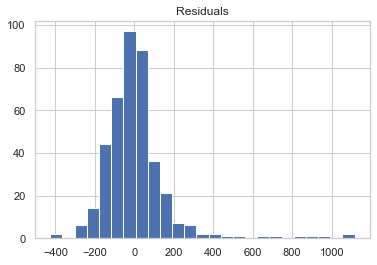

In [19]:
y_pred = model.predict(valid_X)
all_residuals = valid_y - y_pred
print(len(all_residuals[(all_residuals > -300) & (all_residuals < 300)]) /len(all_residuals))
pd.DataFrame({'Residuals': all_residuals}).hist(bins=25)
plt.show()


In [20]:
def train_model(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model
def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(train_y, [train_y.mean()] * len(train_y), model, df=1)
    return AIC_score(train_y, model.predict(train_X[variables]), model)

In [21]:
allVariables = train_X.columns
best_model, best_variables = backward_elimination(allVariables, train_model, score_model, verbose=True)
print('best variables:',best_variables)
regressionSummary(valid_y, best_model.predict(valid_X[best_variables]))

Variables: US, source_a, source_c, source_b, source_d, source_e, source_m, source_o, source_h, source_r, source_s, source_t, source_u, source_p, source_x, source_w, Freq, last_update_days_ago, 1st_update_days_ago, Web_order, Gender_male, Address_is_res
Start: score=7815.74
Step: score=7813.74, remove source_e
Step: score=7811.74, remove last_update_days_ago
Step: score=7809.76, remove source_w
Step: score=7807.79, remove source_p
Step: score=7805.83, remove source_x
Step: score=7803.88, remove source_d
Step: score=7801.99, remove US
Step: score=7800.20, remove Web_order
Step: score=7798.45, remove source_b
Step: score=7796.72, remove source_t
Step: score=7795.03, remove Gender_male
Step: score=7793.50, remove source_o
Step: score=7792.09, remove source_s
Step: score=7791.61, remove source_c
Step: score=7791.19, remove source_m
Step: score=7791.19, remove None
best variables: ['source_a', 'source_h', 'source_r', 'source_u', 'Freq', '1st_update_days_ago', 'Address_is_res']

Regression st

In [22]:
best_model, best_variables = forward_selection(train_X.columns, train_model,
score_model,
verbose=True)
print('best variables:',best_variables)
regressionSummary(valid_y, best_model.predict(valid_X[best_variables]))

Variables: US, source_a, source_c, source_b, source_d, source_e, source_m, source_o, source_h, source_r, source_s, source_t, source_u, source_p, source_x, source_w, Freq, last_update_days_ago, 1st_update_days_ago, Web_order, Gender_male, Address_is_res
Start: score=8123.51, constant
Step: score=7834.90, add Freq
Step: score=7814.54, add Address_is_res
Step: score=7802.53, add 1st_update_days_ago
Step: score=7799.38, add source_r
Step: score=7796.08, add source_a
Step: score=7792.91, add source_u
Step: score=7791.19, add source_h
Step: score=7791.19, add None
best variables: ['Freq', 'Address_is_res', '1st_update_days_ago', 'source_r', 'source_a', 'source_u', 'source_h']

Regression statistics

                      Mean Error (ME) : 4.1171
       Root Mean Squared Error (RMSE) : 169.0312
            Mean Absolute Error (MAE) : 102.8035
          Mean Percentage Error (MPE) : -69.6319
Mean Absolute Percentage Error (MAPE) : 101.1441


In [23]:
best_model, best_variables = stepwise_selection(train_X.columns, train_model,score_model,verbose=True)
print('best variables:',best_variables)
regressionSummary(valid_y, best_model.predict(valid_X[best_variables]))

Variables: US, source_a, source_c, source_b, source_d, source_e, source_m, source_o, source_h, source_r, source_s, source_t, source_u, source_p, source_x, source_w, Freq, last_update_days_ago, 1st_update_days_ago, Web_order, Gender_male, Address_is_res
Start: score=8123.51, constant
Step: score=7834.90, add Freq
Step: score=7814.54, add Address_is_res
Step: score=7802.53, add 1st_update_days_ago
Step: score=7799.38, add source_r
Step: score=7796.08, add source_a
Step: score=7792.91, add source_u
Step: score=7791.19, add source_h
Step: score=7791.19, unchanged None
best variables: ['Freq', 'Address_is_res', '1st_update_days_ago', 'source_r', 'source_a', 'source_u', 'source_h']

Regression statistics

                      Mean Error (ME) : 4.1171
       Root Mean Squared Error (RMSE) : 169.0312
            Mean Absolute Error (MAE) : 102.8035
          Mean Percentage Error (MPE) : -69.6319
Mean Absolute Percentage Error (MAPE) : 101.1441


In [24]:
# all three selected same variables